In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime
from datetime import timedelta
from scipy.stats import linregress

In [2]:
### load COVID-19 cases data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(data.Long, data.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
data_gpd = GeoDataFrame(data, crs=crs, geometry=geometry)
del data_gpd['Lat']; del data_gpd['Long']
data_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(data_gpd.shape)
#data_gpd=data_gpd.groupby('country').sum().reset_index()
data_gpd=data_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(data_gpd.shape)
data_gpd[:5]

(263, 78)
(184, 78)


/home/geiger/anaconda/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,Afghanistan,POINT (65.00000 33.00000),0,0,0,0,0,0,0,0,...,110,120,170,174,237,273,281,299,349,367
1,Albania,POINT (20.16830 41.15330),0,0,0,0,0,0,0,0,...,197,212,223,243,259,277,304,333,361,377
2,Algeria,POINT (1.65960 28.03390),0,0,0,0,0,0,0,0,...,454,511,584,716,847,986,1171,1251,1320,1423
3,Andorra,POINT (1.52180 42.50630),0,0,0,0,0,0,0,0,...,308,334,370,376,390,428,439,466,501,525
4,Angola,POINT (17.87390 -11.20270),0,0,0,0,0,0,0,0,...,5,7,7,7,8,8,8,10,14,16


In [3]:
### load COVID-19 deaths data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(death.Long, death.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
death_gpd = GeoDataFrame(death, crs=crs, geometry=geometry)
del death_gpd['Lat']; del death_gpd['Long']
death_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(death_gpd.shape)
death_gpd=death_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(death_gpd.shape)
death_gpd[:5]

/home/geiger/anaconda/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(263, 78)
(184, 78)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,Afghanistan,POINT (65.00000 33.00000),0,0,0,0,0,0,0,0,...,4,4,4,4,4,6,6,7,7,11
1,Albania,POINT (20.16830 41.15330),0,0,0,0,0,0,0,0,...,10,10,11,15,15,16,17,20,20,21
2,Algeria,POINT (1.65960 28.03390),0,0,0,0,0,0,0,0,...,29,31,35,44,58,86,105,130,152,173
3,Andorra,POINT (1.52180 42.50630),0,0,0,0,0,0,0,0,...,3,6,8,12,14,15,16,17,18,21
4,Angola,POINT (17.87390 -11.20270),0,0,0,0,0,0,0,0,...,0,2,2,2,2,2,2,2,2,2


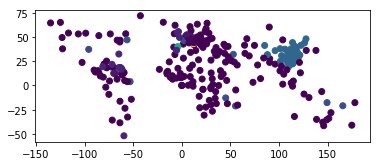

In [4]:
death_gpd.plot(column='3/28/20')

In [5]:
### load COVID-19 recovered data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
rec = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(rec.Long, rec.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
rec_gpd = GeoDataFrame(rec, crs=crs, geometry=geometry)
del rec_gpd['Lat']; del rec_gpd['Long']
rec_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(rec_gpd.shape)
rec_gpd=rec_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(rec_gpd.shape)
rec_gpd[:5]

(249, 78)
(184, 78)


/home/geiger/anaconda/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,Afghanistan,POINT (65.00000 33.00000),0,0,0,0,0,0,0,0,...,2,2,2,5,5,10,10,10,15,18
1,Albania,POINT (20.16830 41.15330),0,0,0,0,0,0,0,0,...,31,33,44,52,67,76,89,99,104,116
2,Algeria,POINT (1.65960 28.03390),0,0,0,0,0,0,0,0,...,31,31,37,46,61,61,62,90,90,90
3,Andorra,POINT (1.52180 42.50630),0,0,0,0,0,0,0,0,...,1,1,10,10,10,10,16,21,26,31
4,Angola,POINT (17.87390 -11.20270),0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,2,2,2


In [6]:
def doubling_time(sub_sample, inc, datatype):
    el=0
    slope_ls=[]
    while el+inc < len(sub_sample):

        s,i,r,p,std = linregress(sub_sample.index[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
        #print (el, s, 1/s)
        slope_ls.append(1/s)
        el=el+1
    return slope_ls
        #plt.plot(xx[:el+inc],xx[:el+inc]*s+i)

def plot_cty(ctyls, datatypels, inc, case_th, death_th, opath, save=False):
    colorls=['b','r']
    # make figure + axes
    fig, axs = plt.subplots(len(ctyls),len(datatypels)+1,figsize=(5*(len(datatypels)+1),5*len(ctyls)),tight_layout=True)
    for ctyno, cty in enumerate(ctyls):
        for datano, datatype,color in zip(range(len(datatypels)),datatypels,colorls):
            if datatype=='cases':
                sample_all=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # cases
                sample_rec=rec_gpd[rec_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # recovered
                sample=sample_all - sample_rec
                sample_rec.index=pd.to_datetime(sample_rec.index)
                sample_rec.columns=['recovered']
                sample_all.index=pd.to_datetime(sample_all.index)
                sample_all.columns=['total']   
                low_th=case_th
            elif datatype=='deaths':
                sample=death_gpd[death_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
                low_th=death_th
                #datano=datano+1
            else:
                print('{0} not defined. Aborted!'.format(datatype))
                break
            sample.index=pd.to_datetime(sample.index)
            sample.columns=[datatype]
            # first and third  column plot
            axs[ctyno,2*datano].set_xlabel('time')
            axs[ctyno,2*datano].set_title(cty)
            sub_sample=sample[sample[datatype] > low_th]
            axs[ctyno,2*datano].set_ylabel('{0} > {1}'.format(datatype, low_th))
            axs[ctyno,2*datano].set_xlim([sub_sample.index[0]- timedelta(days=1),sub_sample.index[-1]+ timedelta(days=1)])
            if datatype == 'deaths':
                axs[ctyno,2*datano].bar(sub_sample.index, sub_sample.iloc[:,0], color=color)
            elif datatype == 'cases':
                #axs[ctyno,2*datano].plot(sub_sample.index, np.log10(sub_sample.iloc[:,0]),'o-', color=color)
                axs[ctyno,2*datano].plot(sub_sample.index, sub_sample.iloc[:,0],'o-', color=color, label=datatype)
                sample.columns=[datatype]
                sub_sample_rec=sample_rec[sample_rec['recovered'] > low_th]
                axs[ctyno,2*datano].plot(sub_sample_rec.index, sub_sample_rec.iloc[:,0],'o-', color='g', label='recovered')
                sub_sample_all=sample_all[sample_all['total'] > low_th]
                axs[ctyno,2*datano].plot(sub_sample_all.index, sub_sample_all.iloc[:,0],'o-', color='k', label='total')
                
                #axs[ctyno,2*datano].set_yscale('log')
            [lab.set_rotation(40) for lab in axs[ctyno,2*datano].get_xticklabels()]

            # second column plot, doubling time of cases and deaths
            axs[ctyno,1].set_xlabel('time')
            axs[ctyno,1].set_ylabel('last {0} days-estimated doubling time in days'.format(inc))
            axs[ctyno,1].set_ylim([1.8,21])
            axs[ctyno,1].set_title(cty)
            sub_sample=sub_sample.reset_index()
            xx=sub_sample.index
            axs[ctyno,1].plot(sub_sample['index'][inc:],doubling_time(sub_sample=sub_sample, inc=inc, datatype=datatype),'-o', color=color, label='based on {0} > {1}'.format(datatype, low_th))
            [lab.set_rotation(40) for lab in axs[ctyno,1].get_xticklabels()]

            print ('total {0}: {1} since '.format(datatype,sample.iloc[-1,0]), sample.index[0])
        print ('last update {0}'.format(sample.index[-1]))
        axs[ctyno,1].legend()
        axs[ctyno,0].legend()
    if save==True:
        plt.savefig(opath)
    #print (sample)

/home/geiger/anaconda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


total cases: 109710 since  2020-01-22 00:00:00
total deaths: 16523 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00
total cases: 74674 since  2020-01-22 00:00:00
total deaths: 1810 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00
total cases: 96238 since  2020-01-22 00:00:00
total deaths: 13341 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00
total cases: 81535 since  2020-01-22 00:00:00
total deaths: 8926 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00
total cases: 347033 since  2020-01-22 00:00:00
total deaths: 10783 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00
total cases: 51992 since  2020-01-22 00:00:00
total deaths: 5385 since  2020-01-22 00:00:00
last update 2020-04-06 00:00:00


/home/geiger/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


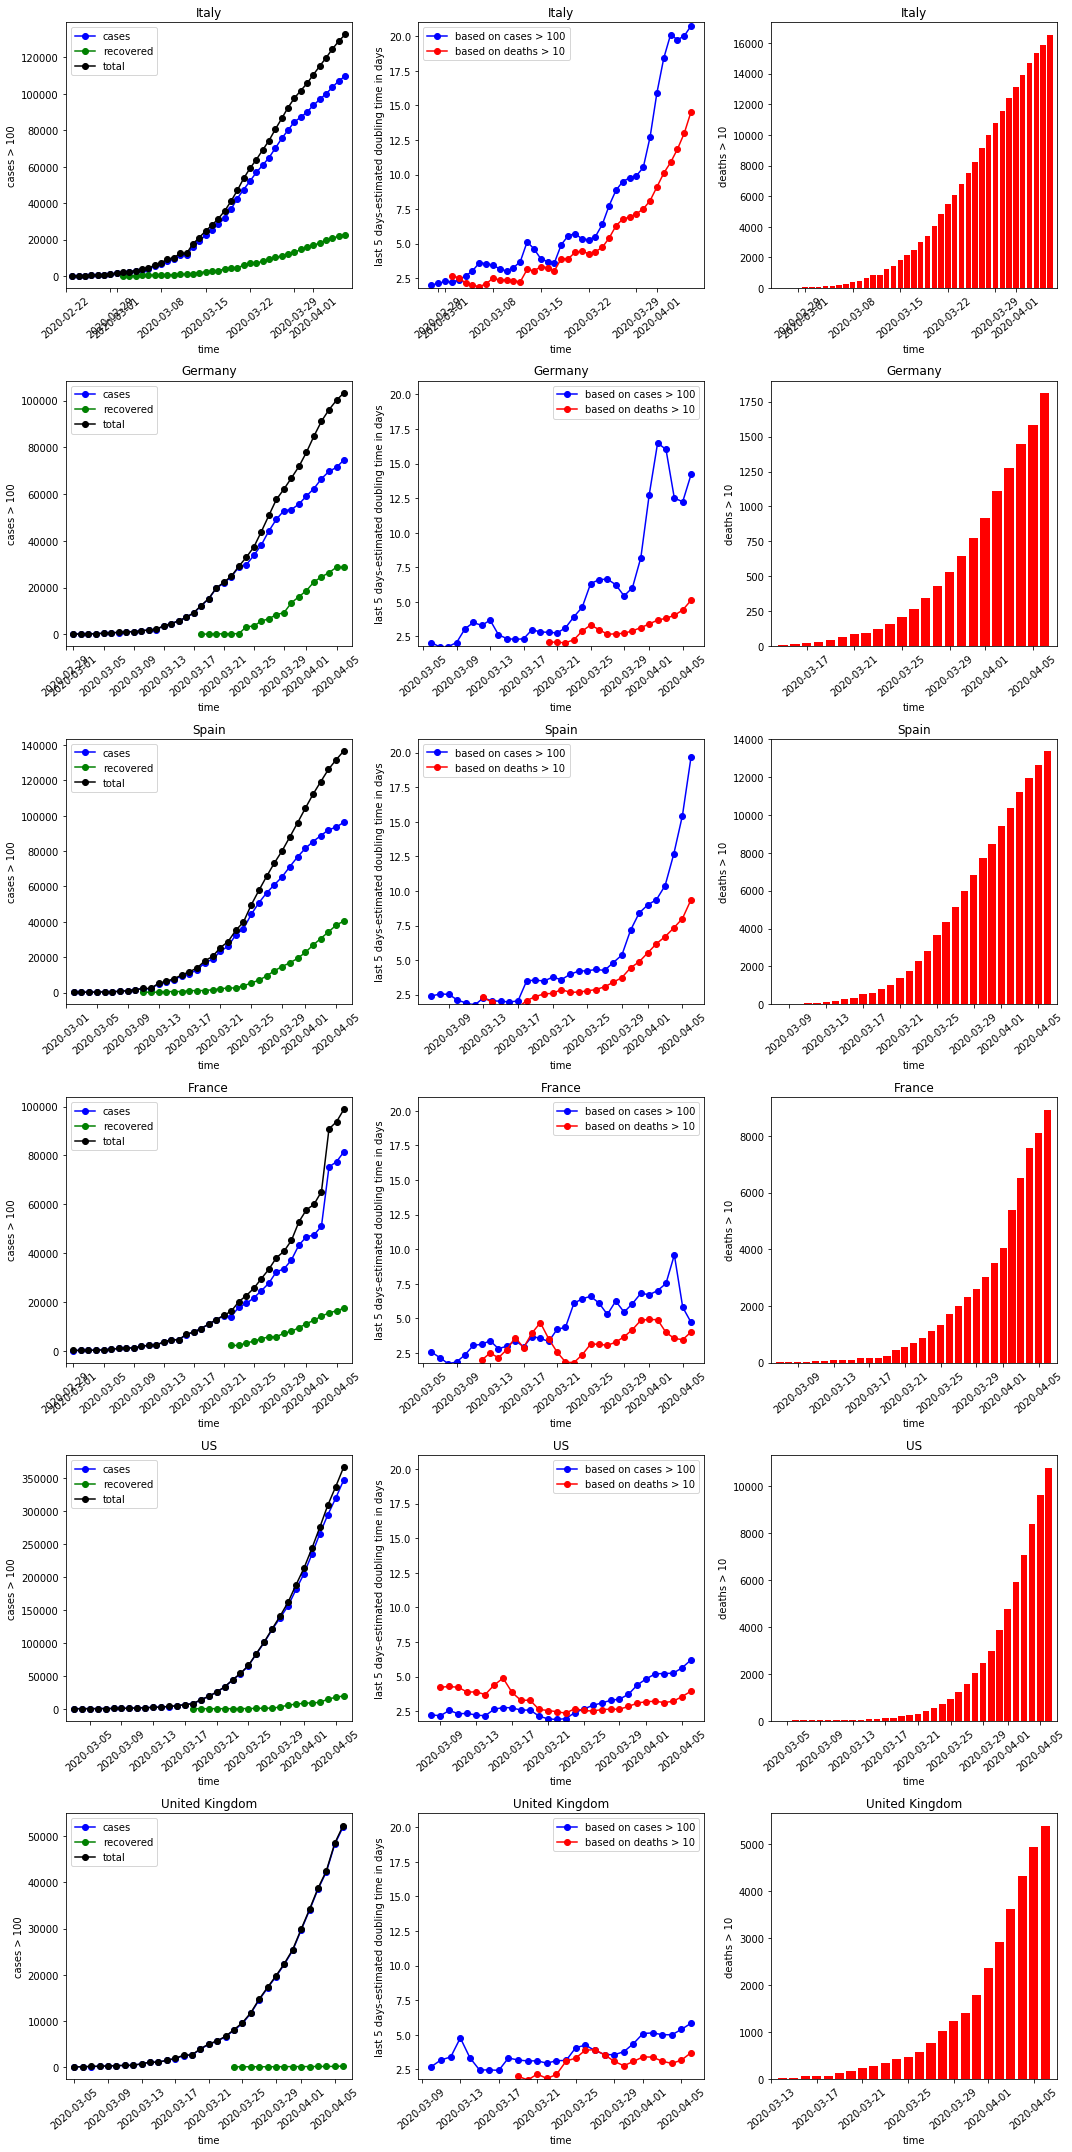

In [7]:
### plot country data
# choose country
ctyls=['Italy','Germany','Spain', 'France','US','United Kingdom']
#ctyls=['China','Korea','Germany']
datatypels=['cases','deaths']
opath='COVID-19_doubling-time_analysis_by_country.pdf'
plot_cty(ctyls = ctyls, datatypels = datatypels, inc=5, case_th=100, death_th=10, opath=opath, save=True)


0 0.4501583092656108 2.2214407230012085 0.06849801785322292
1 0.5448448152236313 1.8353849978173153 0.056156327088768616
2 0.5409277981433223 1.848675559718681 0.05792015077352517
3 0.4707051979680024 2.1244719716649016 0.06701972307463705
4 0.3207916544896124 3.117288077805594 0.027270139971810457
5 0.27991564053471407 3.572504909299571 0.015187246376693199
6 0.29980048751911265 3.335551613925407 0.01977769547838502
7 0.26953973629206623 3.710028115915444 0.023882858197421808
8 0.379990715638915 2.631643245068774 0.0589618303491973
9 0.42535247914413876 2.350991351953849 0.056321613597805416
10 0.4347221059354851 2.3003201041458077 0.05453681579048293
11 0.42713775018625366 2.3411651149165564 0.056578673961046
12 0.3331031409724705 3.002073162926571 0.0026727781633818395
13 0.3529392255536552 2.8333489949475057 0.009426957381569005
14 0.35664690935316745 2.80389363758584 0.008502084401422983
15 0.36239387415913704 2.7594285425500122 0.007471233090589349
16 0.32127471513365724 3.112601

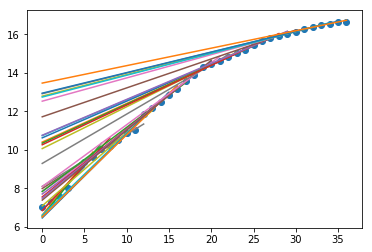

In [8]:
cty='Germany'; datatype='cases'
sample=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
sample.index=pd.to_datetime(sample.index)
sample.columns=[datatype]
sub_sample=sample[sample[datatype] > 100]
sub_sample=sub_sample.reset_index()
xx=sub_sample.index
plt.scatter(xx, np.log2(sub_sample[datatype]))
el=0
inc=5
while el+inc < len(sub_sample):
    
    s,i,r,p,std = linregress(xx[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
    print (el, s, 1/s, std)
    el=el+1
    plt.plot(xx[:el+inc],xx[:el+inc]*s+i)